# DATA LOAD

In [2]:
from transformers import AutoTokenizer
import json
import os
from tqdm.auto import tqdm
from datasets import load_dataset, load_from_disk

wiki_path = '../../../data/wikipedia_documents.json'
with open(wiki_path, 'r',encoding='utf-8') as f:
    wiki = json.load(f)

In [4]:
dataset = load_from_disk('../../../data/train_dataset')
train_dataset = dataset['train']
val_dataset = dataset['validation']

# PREPROCESSING

In [5]:
import re

def preprocess(text: str) -> str:
    text = re.sub(r"\\\\+n", " ", text)  # \\\\n 따위의 이상한 개행문자 제거
    text = re.sub(
        r"([^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z\d\s\.\,\'\"\<\>\!\@\#\$\%\^\&\*\(\)\[\]\_\+\-’‘“”《》〈〉~])",
        "",
        text,
    )

    text = re.sub(r"(\\(\\)|\\[\\])", "", text)  # 빈 괄호 제거
    text = re.sub(r"\\s+", " ", text).strip()  # 중복 공백 제거

    return text

In [6]:
import pandas as pd

wiki_df = pd.DataFrame(wiki).T
wiki_df = wiki_df[["text", "title", "document_id"]]
wiki_df
wiki_df["text"] = wiki_df["text"].apply(preprocess)
wiki_df.drop_duplicates("text", inplace=True)
wiki_df.reset_index(drop=True, inplace=True)
trash = wiki_df[wiki_df.document_id == 40965] #document_id == 40965
trash

,text,title,document_id
37157,"11,172글자를 1줄에 28글자씩 399줄로 배열하여 모두 나열하면 다음과 같다....",한글 음절,40965


In [7]:
wiki_df.drop(40965,inplace=True)
wiki_df.reset_index(drop=True, inplace=True)

In [8]:
from unidecode import unidecode
from datasets import Dataset

context = list(dict.fromkeys([v['text'] for v in wiki.values()]))

context = [{'text': c} for c in context]

print(len(context))

56737


# Answer EDA

In [9]:
from mecab import MeCab
import seaborn as sns
import matplotlib.pyplot as plt

mecab = MeCab()

## Train Dataset에 대한 Answer EDA

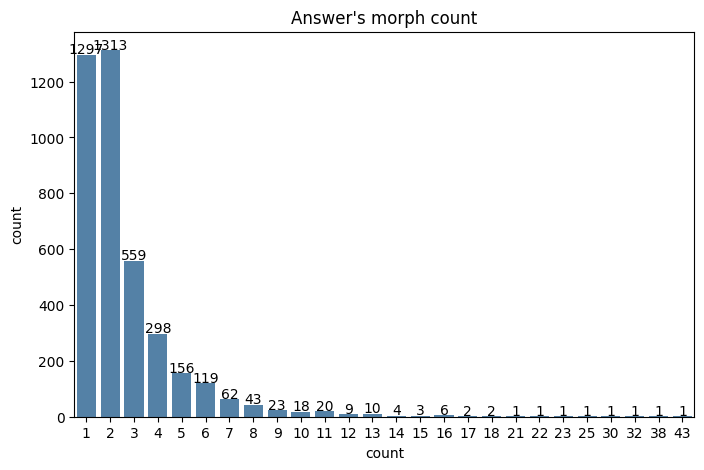

In [10]:
train_df = pd.DataFrame(train_dataset)
train_df['answer_t'] = train_df['answers'].apply(lambda x: x['text'][0])
answers = train_df.answer_t
answers = answers.apply(preprocess)
answers = train_df.answer_t.to_list()
answers = [re.sub( r"([^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z\d\s\.\,\!\@\#\$\%\^\&\*\(\)\[\]\_\+\-~])","",answer) for answer in answers]

morphs = [mecab.pos(a) for a in answers]
count_morphs = [len(m) for m in morphs]
count_morphs= pd.DataFrame(count_morphs,columns=['count'])

plt.figure(figsize = (8, 5))
ax = sns.countplot(x="count", data=count_morphs, color='steelblue')
for patch in ax.patches:
    ax.text(x = patch.get_x() + patch.get_width()/2,
               y = patch.get_height() + len(count_morphs)*0.001,
               s = int(patch.get_height()),
               ha = 'center')
plt.title("Answer\'s morph count")
plt.show()

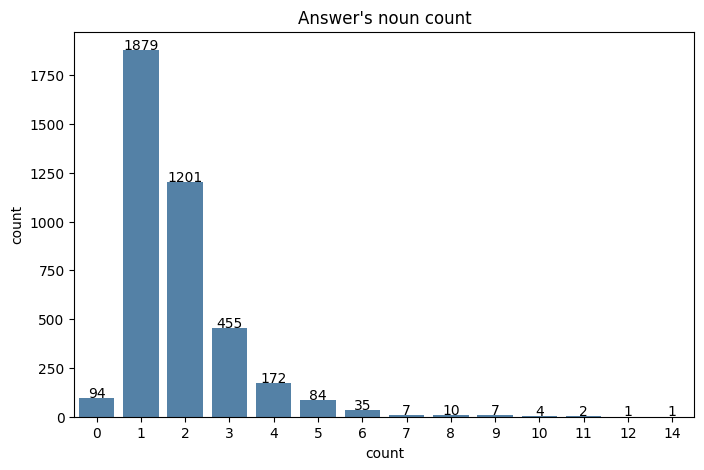

In [11]:
nouns = [mecab.nouns(a) for a in answers]
count_nouns = [len(n) for n in nouns]
count_nouns= pd.DataFrame(count_nouns,columns=['count'])

plt.figure(figsize = (8, 5))
ax = sns.countplot(x="count", data=count_nouns, color='steelblue')
for patch in ax.patches:
    ax.text(x = patch.get_x() + patch.get_width()/2,
               y = patch.get_height() + len(count_nouns)*0.001,
               s = int(patch.get_height()),
               ha = 'center')

plt.title("Answer\'s noun count")
plt.rc('font', size = 11)
plt.show()


### 이때 명사가 포함되지 않은 정답은 어떻게 생겼는지?

In [27]:
zero_noun = count_nouns[count_nouns['count'] == 0]
zero_pos = []
# print(zero_noun.index)
for i in zero_noun.index:
    zero_pos.append(mecab.pos(answers[i]))
zero_pos

Index([  26,   41,   50,  265,  311,  336,  345,  374,  425,  432,  498,  543,
        595,  598,  646,  661,  705,  713,  732,  776,  854,  857,  939,  940,
        972, 1133, 1139, 1170, 1231, 1285, 1302, 1305, 1447, 1481, 1511, 1517,
       1546, 1591, 1651, 1713, 1763, 1782, 1839, 2013, 2063, 2138, 2255, 2281,
       2347, 2363, 2440, 2458, 2465, 2498, 2501, 2559, 2580, 2727, 2730, 2755,
       2773, 2842, 2861, 2869, 2871, 2888, 2917, 2992, 3060, 3071, 3182, 3183,
       3259, 3280, 3337, 3356, 3376, 3379, 3419, 3439, 3488, 3521, 3538, 3555,
       3558, 3566, 3581, 3596, 3602, 3624, 3693, 3774, 3819, 3822],
      dtype='int64')


[[('215', 'SN'), ('km', 'SL')],
 [('NADPH', 'SL')],
 [('2002', 'SN')],
 [('트', 'VV'), ('랴', 'EC'), ('피', 'XR'), ('친', 'XSA+EC+JX')],
 [('끊김', 'VV+ETN')],
 [('하', 'VV'), ('라', 'EC')],
 [('마슈', 'VV+EP+EC')],
 [('Presocratics', 'SL')],
 [('3', 'SN')],
 [('LPAT', 'SL')],
 [('ㅋㅋㅋ', 'IC')],
 [('남', 'VV'), ('구', 'EC')],
 [('1053', 'SN')],
 [('범연', 'XR')],
 [('1908', 'SN')],
 [('안', 'MAG'), ('채', 'VV+EC')],
 [('2014', 'SN')],
 [('.', 'SY'), ('376', 'SN')],
 [('하', 'VV'), ('야', 'EC')],
 [('1994', 'SN')],
 [('2012', 'SN')],
 [('FEVE', 'SL')],
 [('603', 'SN')],
 [('놀리', 'VV'), ('기', 'ETN'), ('위해', 'VV+EC')],
 [('1801', 'SN')],
 [('하얀', 'VA+ETM')],
 [('S', 'SL')],
 [('1988', 'SN')],
 [('희', 'VA'), ('민', 'EC')],
 [('837', 'SN')],
 [('1097', 'SN')],
 [('22', 'SN')],
 [('3', 'SN')],
 [('0', 'SN'), ('.', 'SY'), ('18', 'SN'), ('mm', 'SL')],
 [('1995', 'SN')],
 [('퓌스콘', 'UNKNOWN')],
 [('3', 'SN'), ('kHz', 'SL')],
 [('FNC', 'SL')],
 [('SoC', 'SL')],
 [('1868', 'SN')],
 [('DIA', 'SL'), ('TV', 'SL')],
 [('

In [36]:
check_row = train_df.loc[498]
print(check_row.title)
print(check_row.context)
print(check_row.question)
print(check_row.answers["text"])
check_row.context.find("ㅋㅋㅋ ")

ㅋㅋ
'ㅋㅋ'은 일반적으로 웃음소리를 표현할 때 사용된다. 통신체에서는 웃는 모습을 직접적으로 보여줄 수 없기 때문에 의성어를 사용하는 경우가 많은데 그 중에서 '킥킥', '큭큭'을 초성체로 바꾸어 사용한 것이 'ㅋㅋ'에 해당한다. 이에 대해 2001년 연구에서는 "자음만 가지고 표시하여 통신상의 재미를 더하기 위한 방법으로 사용되고 있다"고 해석한 바 있다. \n\nㅋ자를 웃음소리를 의미하는 것으로 사용할 때, 'ㅋ'자 한 개에서 'ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ...'하는 식으로 열 타 이상 한 줄 넘게까지 쓰이기도 한다 ㅋ자를 얼마나 많이 썼느냐에 따라 그 느낌과 의미는 달라진다. 신조어를 전문으로 연구하는 이재현 문화평론가는 《한국일보》의 기고글에서 그 종류와 느낌이 대략 다음과 같다고 보았다\n* ㅋ - 일반적으로 무심하게 동의하려는 상황에서 쓰인다. 다른 말끝에 붙였을 때, 이를테면 '그래ㅋ', '좋네ㅋ', '올ㅋ' 등은 웃음 자체라기보다는 입꼬리가 아주 살짝 올라간 상황이라는 느낌을 준다. 의성어로는 "큭" 혹은 "킥"으로 해석될 수 있다. 한편 '뭐해?ㅋ', '미안ㅋ'의 경우 'ㅋ'는 상투적인 군말의 역할을 한다.\n* ㅋㅋ - 위의 것보다 ㅋ자가 하나가 더 많으나 오히려 형식적이라는 느낌을 준다. 좋게는 '그렇군'을 뜻하거나, 조금 나쁘게는 대화상에서 의례적으로 추임새를 넣고 있다는 느낌을 준다. 'ㅋㅋ'은 미혼남녀들이 가장 싫어하는 성의 없는 메신저 말투로 선정되기도 했다. 다만 회사 상사에게 대답하는 경우 같은 공적인 상황에서는 '네ㅋㅋ'와 같은 대답은 가벼워 보인다는 조사도 있었다. \n* ㅋㅋㅋ - 비교적 중립적이면서도 가장 많이 사용되는 용법이다. 웃는 감정을 그대로 표현한다는 뉘앙스를 갖는다.\n* ㅋㅋㅋㅋ... - 여기서부터는 "정말 웃긴다"라는 반응을 나름 정성들여서 표현하는 느낌을 준다. 네 개부터 그 이상은 의미의 함축과 정서의 강도가 거의 같으며, 이런 점에서 'ㅋㅋㅋㅋ'는 실질적으로 웃긴다는 것을 표현하는 최소 조건에 해당한다.
웃는 

792

In [32]:
check_row = train_df.loc[311]
print(check_row.title)
print(check_row.context)
print(check_row.question)
print(check_row.answers["text"])

대한민국의 온라인 개학
온라인 개학을 함으로써 기술의 발전을 앞당겨 줄 수도 있다는 시각이 있다.\n\nEBS 온라인 클래스는 초기 기술이 좋지 않아 2020년 4월 기준으로 매일 수 시간씩 접속이 원활하지 않았다. 불안정한 시스템으로 인한 접속 장애와 속도 저하, 영상 끊김이 초기에 지적되었으며 이후 EBS온라인클래스는 급격히 안정화되면서 끊김이 없어졌다. \n\n또한 인터넷 강의와 다를 것이 없어 실제 수업보다 집중하기 어려운 환경이라는 지적도 있다. 공부에 의욕이 있는 사람만 하는 학습. 시스템의 오류로 강의를 모두 다 들어도 완료 표시가 뜨지 않을 때가 있다. 그렇다면 다시 새로고침하거나, 브라우저를 바꾸어 보거나, 동시간대 접속자가 적은 시간대를 골라서 들어가는 법이 있다.\n\n온라인 수업을 하고도 중간고사를 보는 학교가 있다. 온라인 수업은 실제 학교 수업보다는 효과가 떨어지기 때문에, 선행을 하지 않은 학생은 발등에 불이 떨어진 셈이다. \n\n온라인 수업 시스템에 허점도 있어, 명령어 하나로 '학습 완료' 로 처리되었다. 이 명령어가 SNS상에서 퍼지며 이걸 악용하는 학생들이 늘고 있다. 현재는 부정 수강으로 처리된다.\n\n학생들의 시력에 대한 논란이 있다. 하루 종일 모니터를 보고 있는 것에 대해 시력 저하에 대해 우려하는 사람들이 많아지고 있다.
초창기 EBS온라인클래스의 문제들 중 빠른 속도로 시스템이 안정되면서 해결된 문제점은?
['끊김']


## Train+Validation Dataset에 대한 Answer EDA

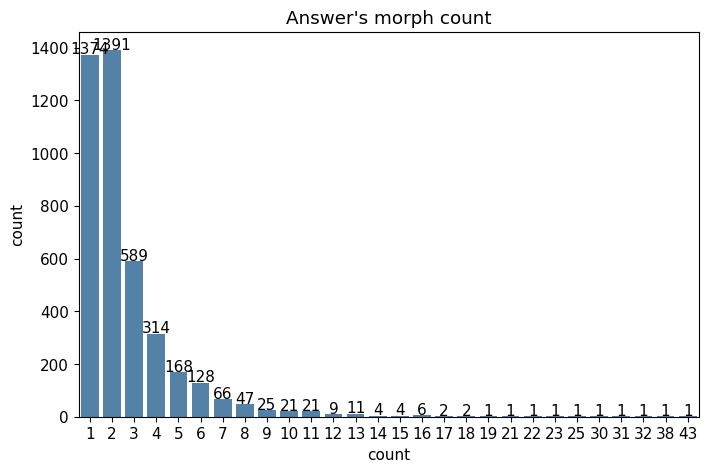

In [38]:
total_df = pd.DataFrame(train_dataset)
total_df = pd.concat([total_df, pd.DataFrame(val_dataset)])
total_df.reset_index(drop=True, inplace=True)
total_df['answer_t'] = total_df['answers'].apply(lambda x: x['text'][0])
answers = total_df.answer_t
answers = answers.apply(preprocess)
answers = total_df.answer_t.to_list()
answers = [re.sub( r"([^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z\d\s\.\,\!\@\#\$\%\^\&\*\(\)\[\]\_\+\-~])","",answer) for answer in answers]

answers #= answers
mecab = MeCab()
morphs = [mecab.pos(a) for a in answers]
count_morphs = [len(m) for m in morphs]
count_morphs= pd.DataFrame(count_morphs,columns=['count'])

plt.figure(figsize = (8, 5))
ax = sns.countplot(x="count", data=count_morphs, color='steelblue')
for patch in ax.patches:
    ax.text(x = patch.get_x() + patch.get_width()/2,
               y = patch.get_height() + len(count_morphs)*0.001,
               s = int(patch.get_height()),
               ha = 'center')
    
plt.title("Answer\'s morph count")
plt.show()

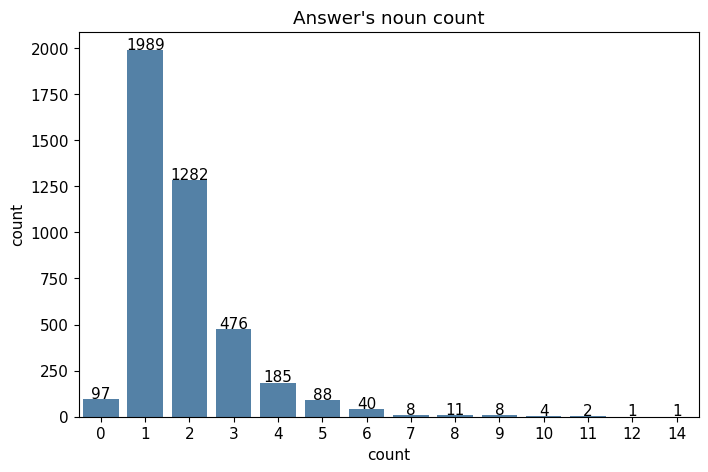

In [39]:
nouns = [mecab.nouns(a) for a in answers]
count_nouns = [len(n) for n in nouns]
count_nouns= pd.DataFrame(count_nouns,columns=['count'])

plt.figure(figsize = (8, 5))
ax = sns.countplot(x="count", data=count_nouns, color='steelblue')
for patch in ax.patches:
    # 2개의 patch 값을 가짐
    ax.text(x = patch.get_x() + patch.get_width()/2,
               y = patch.get_height() + len(count_nouns)*0.001,
               s = int(patch.get_height()),
               ha = 'center')

plt.title("Answer\'s noun count")
plt.rc('font', size = 11)
plt.show()

### 결론
- answer은 대체로 1~2개의 토큰으로 이루어져 있음. (즉 answer 대체로 하나의 단어)
- answer은 대체로 명사
    - 한개의 명사 단어로 이루어진 정답의 비율이 가장 높음
    - 대체로 명사 1~2개로 이루어짐
- 명사가 포함되어있지 않은 정답의 경우
    1. 숫자 (+단위)
    2. 잘 모르는 용어
    3. (etc) "ㅋㅋㅋ" 

# TOKENIZER

## 기존 토크나이저의 성능을 눈으로 체크 
형태소 단위로 잘 쪼개는지 한번 보자

In [41]:
bef_tokenizer = AutoTokenizer.from_pretrained(
    "KoichiYasuoka/roberta-base-korean-morph-upos",
    use_fast=False,
)

In [42]:
context[0]['text']

'이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.'

In [43]:
from mecab import MeCab

mecab = MeCab()
print("토크나이저와 형태소 분석기 결과를 비교합니다 \n")
print(">> text data :",context[0]['text'].replace('\n',' '))

# print("tokenizer :",bef_tokenizer.tokenize(context[0]['text']))
tt = bef_tokenizer.tokenize(context[0]['text'])
tt = [t.replace('#','') for t in tt]
print(">> tokenizer :",tt)
print(">> morph     :", mecab.morphs(context[0]['text']))

토크나이저와 형태소 분석기 결과를 비교합니다 

>> text data : 이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.  이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.  # 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다. # 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.  두 목록은 모두 가나다 순이다.  일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.
>> tokenizer : ['이', '문서', '는', '나라', '목록', '이', '며', ',', '전', '세계', '206', '개', '나라', '의', '각', '현황', '과', '주권', '승인', '정보', '를', '개요', '형태', '로', '나열', '하고', '있', '다', '.', '이', '목록', '은', '명료', '화', '를', '위해', '두', '부분', '으로', '나뉘', '어', '있', '다', '.', '', '첫', '번', '째', '부분', '은', '바티칸', '시국', '과', '팔레스타인', '을', '포함', '하여', '유엔', '등', '국제', '기구', '에', '가입', '되', '어', '국제', '적인', '승인', '을', '널리', '받', '았', '다고', '여기', '는', '195', '개', '나라', '를', '나열', '하고', '있', '다', '.', '', '두', '번', '째', '부분

**눈으로 확인한 결과 분석**
- 형태소 분석기와 토크나이저의 토큰화 결과가 유사함.
- 차이점은 형태소 분석기가 어미를 좀 더 세밀하게 나누는 것 정도?
    - ex. 토크나이저 : '하고', '있', '다' / 형태소분석기 : '하', '고', '있', '다'
    - retriever 성능 상으로는 토크나이저가 더 나을 것으로 예상됨<br>
    (critical한 부분이 아닐 뿐 아니라 너무 세밀하게 쪼개기 보다는 어떤 명사를 하나의 토큰으로 제대로 인식하는 것이 retrieval 성능에 더 좋을 것이라 생각하기 때문)

### 결론
- 기존의 `KoichiYasuoka/roberta-base-korean-morph-upos` tokenizer 에 answer에 등장한 명사를 새로운 vocab으로 추가해보자

## Add new vocab

In [47]:
# load tokenizer vocab
f = open("./vocab.txt", 'r')
lines = f.readlines()
vocab = []
for line in lines:
    line = line.strip()  # 줄 끝의 줄 바꿈 문자 제거
    vocab.append(line)
f.close()

len(context)

56737

In [49]:
answer_n = []
for n in nouns:
    answer_n.extend(n)

answer_n = list(set(answer_n))
len(answer_n)

add_noun = []
for noun in answer_n: 
    if noun not in vocab: 
        # print(noun)
        add_noun.append(noun)

In [50]:
print(len(add_noun))

# 텍스트 파일 경로 및 이름 지정
file_path = "../new_vocab.txt"

# 리스트의 문장을 텍스트 파일에 저장
with open(file_path, "w") as file:
    file.write(" ".join(add_noun))


1843


In [53]:
# check new vocab
file_path = "/opt/ml/input/level2_nlp_mrc-nlp-03-1/code/retriever/new_vocab.txt"

with open(file_path, "r") as file:
    new_vocab = file.readline()

new_vocab = new_vocab.split()
print(new_vocab[:10])


['캐니언', '피사로', '히포크라테스', '아우랑제브', '펩티드', '코마', '요하네스', '몸속', '명진', '북청']


In [56]:
file_path = "/opt/ml/input/level2_nlp_mrc-nlp-03-1/code/retriever/new_vocab.txt"

# 텍스트 파일에서 내용을 읽어 리스트로 추출
with open(file_path, "r") as file:
    string_list = file.readlines()
# 각 문장에서 줄 바꿈 문자(\n) 제거하기
string_list = string_list[0].split()

print(string_list)


1
['캐니언', '피사로', '히포크라테스', '아우랑제브', '펩티드', '코마', '몸속', '명진', '프리맨', '어파', '필리포스', '스티네', '크리크', '번디', '오누', '곽준', '바리사이파', '에드워', '상대론', '익사', '코다', '천인', '헐리우드', '후일라', '청부업자', '우주제국', '인디고', '알프레드', '김동인', '요업', '포에니', '병단', '뭄타즈마할', '천관우', '훈고학', '디나르', '화강암', '내만', '왕명', '민병대', '장헌', '문장대', '강녕전', '레이놀즈', '크로우', '첸노트', '초나라', '드라이아이스', '연대장', '유길준', '스티번', '호른', '신미', '드레스덴', '엔강', '뉴캐슬', '이효상', '안굿', '장로교', '올림픽기', '상공업', '아부카말', '김학규', '니케아', '천년기', '네드', '배달원', '이잔', '알키비아데스', '놀린', '메카닉', '위략', '우이동', '율리우스', '구축함', '분류학', '로던', '치음', '뉘노르스크', '특수부대', '칼로스', '총사령관', '황갈색', '아드리안', '제부', '네스트', '와창', '페르미', '두에', '글래스', '플로린', '맨더', '아우구스트', '부르크', '단군릉', '새러', '그린필드', '시냅스', '카탈루냐', '연남생', '직류', '봉분', '앤더스', '탕롱', '새뮤얼', '도깨비방망이', '토리당', '고비사막', '비딘', '조년', '김교성', '긴모치', '탄트', '루빈', '섹터', '체사레', '채제공', '스테인리스강', '집지', '강장', '벵', '라테라노', '프록터', '샤푸르', '킬리키아', '스펠', '레오니다스', '전남편', '이기룡', '보호구', '틸던', '서사하라', '알서포트', '식산흥업', '세르기우스', '고문서', '심리사', '오딘', '마르세유', '베역', '별사이', '추력',

---

In [66]:
answer_n = []
for n in nouns:
    answer_n.extend(n)

answer_n = list(set(answer_n))
len(answer_n)

# load tokenizer vocab
f = open("./vocab.txt", 'r')
lines = f.readlines()
vocab = []
for line in lines:
    line = line.strip()  # 줄 끝의 줄 바꿈 문자를 제거한다.
    vocab.append(line)
f.close()
add_noun = []
for noun in answer_n: 
    if noun not in vocab: 
        add_noun.append(noun)

In [67]:
print(len(add_noun))

# 텍스트 파일 경로 및 이름 지정
file_path = "./new_vocab.txt"

# 리스트의 문장을 텍스트 파일에 저장
with open(file_path, "w") as file:
    file.write(" ".join(add_noun))


1843
